# Multi-class Clasification on Stack overflow Questions 

## Importing Dependencies

In [1]:
import numpy as np 
import tensorflow as tf 
import os 
import string
import matplotlib.pyplot as plt 

from tensorflow.keras import layers, losses
from tensorflow.keras.utils import text_dataset_from_directory

## Importing Data 

In [2]:
train_dir = os.path.join('data', 'stack_overflow_16k',"train")
test_dir = os.path.join('data', 'stack_overflow_16k',"test")

In [3]:
sample_file = os.path.join(train_dir,'javascript/4.txt')

with open(sample_file) as f: 
    print(f.read())

"setting focus to an input after changing display to ""block"" i cant find the answer to this within a search...using blank i have a div (ac) with an onclick event part of which is to set focus to an input element (gn) within a previously hidden div (as)...i would expect this to work:..ac.onmousedown = function () {.    csect.style.display = ""none"";.    as.style.display = ""block"";.    gn.focus();.}...but didn't, so i added small delay..ac.onmousedown = function () {.    csect.style.display = ""none"";.    as.style.display = ""block"";.    settimeout(function(){.        gn.focus().        },30);.}...which made it work. ..is this delay really necessary? have i missed something?..thanks for any help."



## Load the Dataset

In [4]:
batch_size = 32 
seed = 42 

raw_train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2024-12-25 21:38:11.522471: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-25 21:38:11.522510: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-25 21:38:11.522520: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-25 21:38:11.522792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-25 21:38:11.522804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

Next, we will create a validation and test dataset. We will use the remaining 5000 reviews from the training set for validation.

In [6]:
raw_val_ds = text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [7]:
raw_test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Pre-Processing 

In [8]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation', 
    split='whitespace',
    max_tokens=max_features, 
    output_mode='int', 
    output_sequence_length=sequence_length
)

In [9]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-12-25 21:38:14.260952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's create a function to see the result of using this layer to preprocess some data.

In [10]:
def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [11]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [12]:
print('1133', vectorize_layer.get_vocabulary()[1133])
print('353', vectorize_layer.get_vocabulary()[353])
print('2324', vectorize_layer.get_vocabulary()[2324])
print('8989', vectorize_layer.get_vocabulary()[8989])
print('1000', vectorize_layer.get_vocabulary()[1000])

1133 tree
353 ltdiv
2324 heap
8989 sample1
1000 systemoutprintlnplease


As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [13]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text) 
test_ds = raw_test_ds.map(vectorize_text) 

### Configuring for Performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) 
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE) 

## Model

In [15]:
embedding_dim = 16

In [16]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2), 
    layers.GlobalAveragePooling1D(), 
    layers.Dropout(0.2), 
    layers.Dense(4, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
 # Custom learning rate schedule with warmup
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate,
        first_decay_steps=1000,
        t_mul=2.0,
        m_mul=0.9,
        alpha=0.1
    )

In [19]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0), metrics=['accuracy'])

In [20]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


/opt/anaconda3/envs/tensorflow-course/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-12-25 21:38:15.198218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2973 - loss: 1.3801 - val_accuracy: 0.3425 - val_loss: 1.3581
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4103 - loss: 1.3435 - val_accuracy: 0.4675 - val_loss: 1.3165
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4789 - loss: 1.3012 - val_accuracy: 0.5750 - val_loss: 1.2765
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5482 - loss: 1.2635 - val_accuracy: 0.5763 - val_loss: 1.2513
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5737 - loss: 1.2446 - val_accuracy: 0.5675 - val_loss: 1.2400
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5586 - loss: 1.2196 - val_accuracy: 0.6263 - val_loss: 1.1612
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6120 - loss: 1.1438 - val_accuracy: 0.6794 - val_loss: 1.0852
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6533 - loss: 1.0677 - val_accuracy: 0.692

## Evaluate

In [21]:
history = hist.history
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

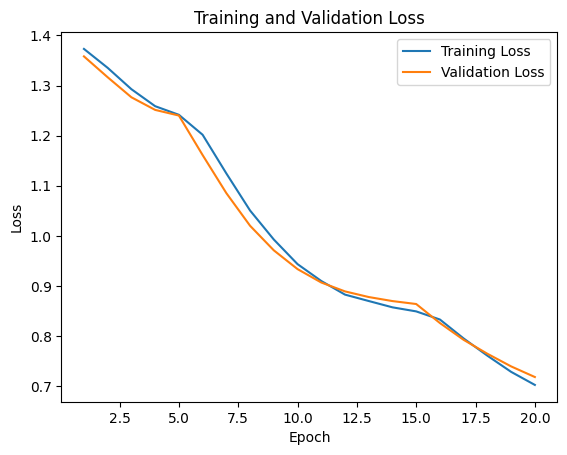

In [23]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

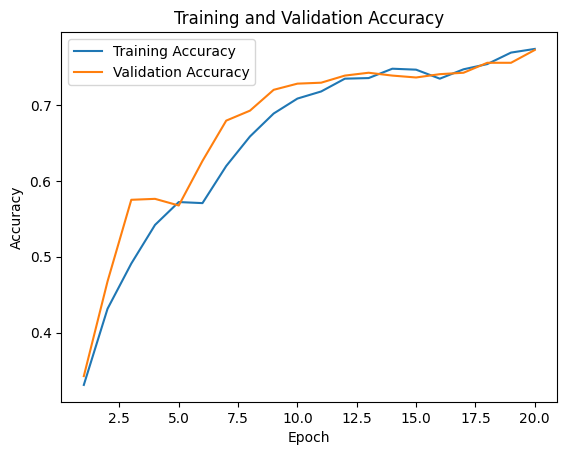

In [24]:
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
loss, acc = model.evaluate(test_ds)
print('loss', loss)
print('acc', acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7465 - loss: 0.7639   
loss 0.7561312317848206
acc 0.750124990940094


Now, Let`s include the TextVectorization layer inside the model so that it is capable of processing raw strings

In [26]:
new_model = tf.keras.Sequential([
    vectorize_layer, 
    model, 
    layers.Activation('sigmoid')
])

In [27]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (1, 250)               │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 4)              │       160,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,068 (625.27 KB)

 Trainable params: 160,068 (625.27 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
new_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
loss, acc = new_model.evaluate(raw_test_ds)
print('loss', loss)
print('acc', acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7461 - loss: 1.1786
loss 1.1767293214797974
acc 0.750124990940094
